<a href="https://colab.research.google.com/github/kavya006/tensorflow-deep-learning/blob/main/WindowGenerator_with_Multiple_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add the relevant imports at the beginning of the notebook

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

# Window Generator for multiple time series in a single dataframe 

## Prepraring dummy multiple time series in a single dataframe

In [3]:
df = pd.read_csv(csv_path).drop_duplicates('Date Time')
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df['date'] = date_time

In [4]:
LABELS = ['T (degC)']
REGRESSORS = ['p (mbar)', 'rh (%)']
DATE = 'date' 
IN_STEPS = 24
OUT_STEPS = 24  
GROUPBY = ['SeriesID']
BATCH_SIZE = 8 

In [5]:
series_1 = df[LABELS + REGRESSORS + [DATE]]
series_1.loc[:, 'SeriesID'] = 1

series_2 = df[LABELS + REGRESSORS + [DATE]]
series_2.loc[:, 'SeriesID'] = 2

series_3 = df[LABELS + REGRESSORS + [DATE]]
series_3.loc[:, 'SeriesID'] = 3 

series = pd.concat([series_1, series_2, series_3], axis=0).reset_index(drop=True)
series

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,T (degC),p (mbar),rh (%),date,SeriesID
0,-8.05,996.50,94.40,2009-01-01 01:00:00,1
1,-8.88,996.62,93.20,2009-01-01 02:00:00,1
2,-8.81,996.84,93.50,2009-01-01 03:00:00,1
3,-9.05,996.99,92.60,2009-01-01 04:00:00,1
4,-9.63,997.46,92.20,2009-01-01 05:00:00,1
...,...,...,...,...,...
210106,-1.61,1001.78,70.60,2016-12-31 19:40:00,3
210107,-3.30,1001.39,76.50,2016-12-31 20:40:00,3
210108,-2.48,1001.00,71.10,2016-12-31 21:40:00,3
210109,-4.45,1000.45,81.30,2016-12-31 22:40:00,3


In [6]:
n = len(df)
train_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[:int(n * 0.7)]).reset_index(drop=True)
val_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[int(n * 0.7):int(n * 0.9)]).reset_index(drop=True)
test_series = series.groupby(GROUPBY, as_index=False).apply(lambda x: x.iloc[int(n * 0.9):]).reset_index(drop=True)
train_series.shape, val_series.shape, test_series.shape

((147075, 5), (42024, 5), (21012, 5))

In [7]:
train_series[GROUPBY].value_counts()

SeriesID
1           49025
2           49025
3           49025
dtype: int64

## Updating the window generator for multiple time series 

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, batch_size, label_columns=[], GROUPBY=None, regressor_columns=[], static_columns=[]):

    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if len(label_columns) != 0:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    
    self.GROUPBY = GROUPBY 
    self.regressor_columns = regressor_columns
    self.static_columns = static_columns

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Batch Size: {self.batch_size}',
        f'Label column name(s): {self.label_columns}',
        f'Additional Regressor column name(s): {self.regressor_columns}', 
        f'GROUPBY column(s): {self.GROUPBY}' 
        ])

In [9]:
def preprocess_dataset(self:WindowGenerator, data:pd.DataFrame):
    try:
      if np.vstack(data.index).shape[1] != 1:
        data = data.reset_index() 

      by = self.GROUPBY + [DATE] 
      labels = self.label_columns + self.regressor_columns + self.static_columns
      data = data.set_index(by).unstack(-1)
      data = tf.stack([data[label] for label in labels], axis=-1)
      
      if data.ndim != 3:
          data = data[None, None, tf.newaxis]
    except Exception as e:
      print('Error while processing dataset', e)
    return data 

def update_datasets(self:WindowGenerator, train_df:pd.DataFrame, val_df:pd.DataFrame, test_df:pd.DataFrame, norm:bool=False):
    # Store the raw data.
    self.train_df = self.preprocess_dataset(train_df)
    self.val_df = self.preprocess_dataset(val_df)
    self.test_df = self.preprocess_dataset(test_df)

    if norm:
      train_mean = tf.reduce_mean(self.train_df, axis=1, keepdims=True)
      train_std = tf.math.reduce_std(self.train_df, axis=1, keepdims=True)

      self.train_df = (self.train_df - train_mean) / train_std
      self.val_df = (self.val_df - train_mean) / train_std
      self.test_df = (self.test_df - train_mean) / train_std

      self.train_mean = train_mean 
      self.train_std = train_std 
      self.norm = norm 

    labels = self.label_columns + self.regressor_columns + self.static_columns
    self.column_indices = {name: i for i, name in enumerate(labels)}

WindowGenerator.preprocess_dataset = preprocess_dataset 
WindowGenerator.update_datasets = update_datasets

In [10]:
w1 = WindowGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS, batch_size=BATCH_SIZE, label_columns=LABELS, GROUPBY=GROUPBY, regressor_columns=REGRESSORS)
w1.update_datasets(train_series, val_series, test_series, norm=True)

In [11]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Batch Size: 8
Label column name(s): ['T (degC)']
Additional Regressor column name(s): ['p (mbar)', 'rh (%)']
GROUPBY column(s): ['SeriesID']

In [12]:
def split_window(self, features:tf.Tensor):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None: 
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]] 
          for name in self.label_columns], axis=-1)
          
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels 
WindowGenerator.split_window = split_window

In [13]:
example_window = tf.stack([
    np.array(series_1.set_index(GROUPBY + [DATE])[:w1.total_window_size]), 
    np.array(series_1.set_index(GROUPBY + [DATE])[2:2+w1.total_window_size]),
    np.array(series_1.set_index(GROUPBY + [DATE])[4:4+w1.total_window_size])
])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 3)
Inputs shape: (3, 24, 3)
Labels shape: (3, 24, 1)


In [14]:
w1.example = (example_inputs, example_labels)

def plot(self, model=None, plot_col=LABELS[0], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [MS]')

WindowGenerator.plot = plot

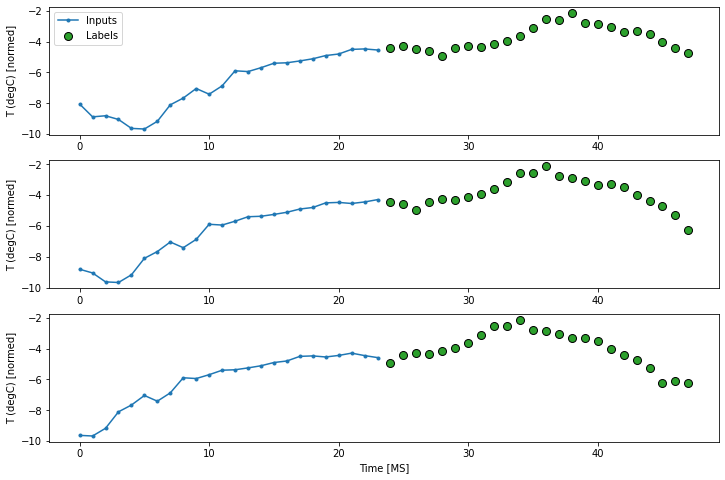

In [15]:
w1.plot()

In [16]:
def make_cohort(self, data:np.array) -> tf.data.Dataset:
    data = np.array(data, dtype=np.float32) 
    ds = timeseries_dataset_from_array(
        data=data, 
        targets=None, 
        sequence_length=self.total_window_size, 
        sequence_stride=1, 
        shuffle=True, 
        batch_size=self.batch_size
    )
    ds = ds.map(self.split_window) 
    return ds 

WindowGenerator.make_cohort = make_cohort

In [17]:
w1.make_cohort(series_1.set_index(GROUPBY + [DATE]))

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [18]:
"""
Reference code from https://stackoverflow.com/questions/49994496/mixing-multiple-tf-data-dataset
"""

def stack_windows(*windows):
    features = tf.concat([window[0] for window in windows], 0) 
    labels = tf.concat([window[1] for window in windows], 0) 
    return (features, labels)
    
def make_dataset(self, data:tf.Tensor) -> tf.data.Dataset:    
    # num_cohorts = min(10, len(cluster_cohorts))
    # print(cluster, num_cohorts)
    ds_list = tuple(self.make_cohort(data[i]) for i in range(len(data)))
    ds = tf.data.Dataset.zip(ds_list)
    ds = ds.map(stack_windows)
    ds = ds.unbatch() 
    ds = ds.shuffle(10, seed=0)
    ds = ds.batch(self.batch_size) 
    ds = ds.prefetch(1)
    return ds 

WindowGenerator.make_dataset = make_dataset


In [19]:
w1.make_dataset(w1.train_df)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [20]:
@property
def train(self) -> tf.data.Dataset:
    return self.make_dataset(self.train_df)

@property 
def val(self) -> tf.data.Dataset:
    return self.make_dataset(self.val_df)

@property 
def test(self) -> tf.data.Dataset:
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting"""
    result = getattr(self, '_example', None) 
    print('Number of train batches:', len(list(self.train.as_numpy_iterator())))
    if result is None: 
        result = next(iter(self.train)) 
        self._example = result 
    return result 

WindowGenerator.train = train 
WindowGenerator.test = test 
WindowGenerator.val = val 
WindowGenerator.example = example 

In [21]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (8, 24, 3)
Labels shape (batch, time, features): (8, 24, 1)


Number of train batches: 18367


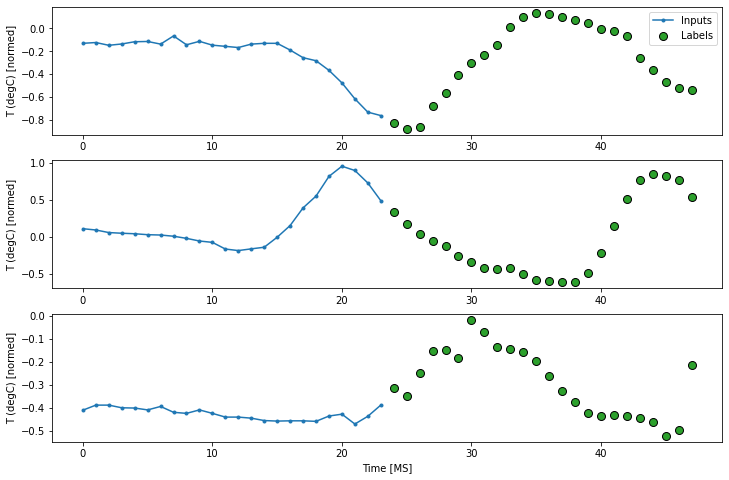

In [22]:
w1.plot()

# Baseline models

In [23]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY, label_columns=LABELS, regressor_columns=REGRESSORS)
single_step_window.update_datasets(train_series, val_series, test_series, norm=True)

In [24]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [25]:
baseline = Baseline(label_index=single_step_window.column_indices[LABELS[0]])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

5253/5253 [==============================] - 27s 5ms/step - loss: 0.0130 - mean_absolute_error: 0.0789


In [26]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, batch_size=BATCH_SIZE, GROUPBY = GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS) 
wide_window.update_datasets(train_series, val_series, test_series, norm=True)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Batch Size: 8
Label column name(s): ['T (degC)']
Additional Regressor column name(s): ['p (mbar)', 'rh (%)']
GROUPBY column(s): ['SeriesID']

Number of train batches: 18376


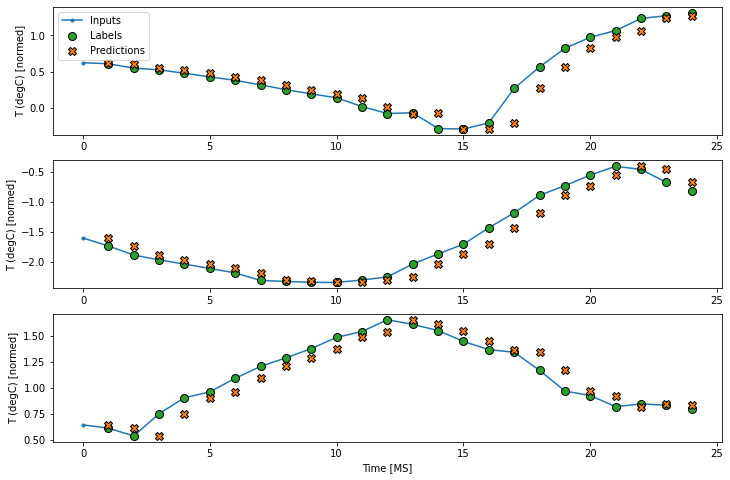

In [27]:
wide_window.plot(baseline)